# 📈 Predicting Project Outcomes from Evaluation Text

In this third notebook, I implement a machine learning model using textual data extracted from project evaluations as predictors. The main objectives are:

1. To compare the predictive performance of different sections of the evaluation text in estimating project outcome ratings.
2. To identify the most relevant words or phrases (n-grams) that contribute to the model's predictions.

## 1. Setup and Data Loading

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
import string
import optuna
import numpy as np
import pickle
import seaborn as sns
import requests
import pdfplumber 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from mord import OrdinalRidge  
from sklearn.model_selection import train_test_split
from io import BytesIO
from tqdm import tqdm

# determine working directories (notebook CWD)
script_dir = os.getcwd()
parent_dir = os.path.dirname(script_dir)
data_dir = parent_dir + '\\1_Data'

# Read data
excel_file = os.path.join(data_dir, 'IEG_ICRR_PPAR_Ratings_2025-03-12.xlsx')
df = pd.read_excel(excel_file)

# Output directory:
output = os.path.join(os.path.dirname(script_dir), '3_Outputs')
output = "C:\\Users\\wb592581\\Documents\\"
data_dir = r"C:\Users\wb592581\Documents"

# Filter the dataset to include only projects approved between 2015 to 2025 that are mapped to the Human Development Practice Group. 
df2 = df[
    (df['Approval FY'] >= 2015) &
    (df['Approval FY'] <= 2025) &
    (df['Practice Group'] == 'HD')
]

## 2. Text Extraction

In [3]:
# Extract full text from links
tqdm.pandas()

def extract_text_from_pdf(url):
    try:
        response = requests.get(url, timeout=15)
        response.raise_for_status()
        with pdfplumber.open(BytesIO(response.content)) as pdf:
            text = ''.join(page.extract_text() or '' for page in pdf.pages)
        return text.strip()
    except Exception as e:
        return f"[ERROR] {e}"

df2['Full Text'] = df2['PDF'].progress_apply(extract_text_from_pdf)

100%|██████████| 328/328 [28:09<00:00,  5.15s/it]
C:\Users\wb592581\AppData\Local\Temp\ipykernel_6368\4063980361.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Full Text'] = df2['PDF'].progress_apply(extract_text_from_pdf)


In [4]:
# ----------------------------
# Function to extract sections from full project evaluations
# ----------------------------
def extract_section(text, start_pattern, end_pattern, label):
    # Compile regex patterns (case insensitive)
    start_regex = re.compile(rf"{start_pattern}", re.IGNORECASE)
    end_regex = re.compile(rf"{end_pattern}", re.IGNORECASE)

    # Split text into lines
    lines = text.splitlines()
    start_idx = end_idx = None

    # Identify the index range between start and end patterns
    for i, line in enumerate(lines):
        if start_idx is None and start_regex.search(line.strip()):
            start_idx = i
        elif start_idx is not None and end_regex.search(line.strip()):
            end_idx = i
            break

    # Return the section if both indices are found and valid
    if start_idx is not None and end_idx is not None and end_idx > start_idx:
        return "\n".join(lines[start_idx:end_idx+1])
    else:
        return ""

# ----------------------------
# Apply section extraction to each row
# ----------------------------
def extract_sections(row):
    text = row['Full Text']
    me_section = extract_section(
        text,
        start_pattern=r"\bM&E\s+Design.*Utilization\b", 
        end_pattern=r"\bM&E\s+Quality\s+Rating\b", 
        label="M&E Section"
    )
    me_design = extract_section(
        text,
        start_pattern=r"\bM&E\s+Design\b", 
        end_pattern=r"\bM&E\s+Implementation\b", 
        label="M&E: Design"
    )
    me_implementation = extract_section(
        text,
        start_pattern=r"\bM&E\s+Implementation\b", 
        end_pattern=r"\bM&E\s+Utilization\b", 
        label="M&E: Implementation"
    )
    me_utilization = extract_section(
        text,
        start_pattern=r"\bM&E\s+Utilization\b", 
        end_pattern=r"\bM&E\s+Quality\s+Rating\b", 
        label="M&E: Utilization"
    )
    outcome_section = extract_section(
        text,
        start_pattern=r'[567][\.\)]?\s*Outcome\b.*',
        end_pattern=r'(IEG\s+)?Outcome\s+Rating\b.*',
        label="Outcome Section"
    )
    return pd.Series({
        'M&E Section': me_section,
        'M&E: Design': me_design,
        'M&E: Implementation': me_implementation,
        'M&E: Utilization': me_utilization,
        'Outcome_section': outcome_section
    })

# Apply extraction to the DataFrame
df2[['M&E Section', 'M&E: Design', 'M&E: Implementation', 'M&E: Utilization', 'Outcome_section']] = df2.apply(extract_sections, axis=1)

# ----------------------------
# Convert outcome ratings to numeric scores
# ----------------------------
rating_mapping = {
    'Highly Unsatisfactory': 1, 'Unsatisfactory': 2, 'Moderately Unsatisfactory': 3,
    'Moderately Satisfactory': 4, 'Satisfactory': 5, 'Highly Satisfactory': 6
}
df2['outcome_score'] = df2['IEG Outcome Ratings'].map(rating_mapping)
df2.drop(columns=['IEG Outcome Ratings'], inplace=True, errors='ignore')

# ----------------------------
# Custom words to remove from text
# ----------------------------
custom_stopwords = set([
    "pbf", "ndc", "eur", "rating", "icr", "outcome",
    "unsatisfactory", "satisfactory", "moderately", "highly",
    "monitoring", "design", "implementation", "utilization",
    "lesson", "evaluation", "modest", "bme", "cme", "dlis", "high", 
    "efficiency", "negligible", "substantial", "lessons", "ppmp", "piu",
    "indicators", "independent", "group"
])

# ----------------------------
# Function to clean text for modeling
# ----------------------------
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize spaces

    # Remove full-word stopwords
    pattern = r'\b(?:' + '|'.join(re.escape(word) for word in custom_stopwords) + r')\b'
    text = re.sub(pattern, '', text)

    # Final cleanup
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# ----------------------------
# Apply text cleaning to selected text fields
# ----------------------------
text_vars = ['Full Text', 'M&E Section', 'M&E: Design', 'M&E: Implementation', 'M&E: Utilization', 'Lesson']
df2_cleaned = df2.copy()
for var in text_vars:
    df2_cleaned[var] = df2_cleaned[var].fillna("").apply(clean_text)

C:\Users\wb592581\AppData\Local\Temp\ipykernel_6368\1931054724.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[['M&E Section', 'M&E: Design', 'M&E: Implementation', 'M&E: Utilization', 'Outcome_section']] = df2.apply(extract_sections, axis=1)
C:\Users\wb592581\AppData\Local\Temp\ipykernel_6368\1931054724.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[['M&E Section', 'M&E: Design', 'M&E: Implementation', 'M&E: Utilization', 'Outcome_section']] = df2.apply(extract_sections, axis=1)
C:\Users

## 3. ML Model

In [8]:
# Dictionary to store results
results = {}
N_TRIALS = 15  # Number of optimization trials

# Loop over each text variable
for var in text_vars:
    print(f"\nProcessing text variable: {var}")
    
    # TF-IDF vectorization with 1- to 3-grams
    tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features=5000, stop_words='english')
    X_tfidf = tfidf.fit_transform(df2_cleaned[var])
    y = df2_cleaned["outcome_score"].astype(int)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

    model_results = {}

    # ------------------ LightGBM ------------------
    def objective_lgbm(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.2, log=True)
        }
        model = LGBMRegressor(**params)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        return mean_squared_error(y_test, preds, squared=False)  # RMSE

    study_lgbm = optuna.create_study(direction='minimize')
    study_lgbm.optimize(objective_lgbm, n_trials=N_TRIALS)

    best_lgbm = LGBMRegressor(**study_lgbm.best_params)
    best_lgbm.fit(X_train, y_train)
    model_results['lgbm'] = (best_lgbm, tfidf)

    # ------------------ Random Forest ------------------
    def objective_rf(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 15)
        }
        model = RandomForestRegressor(**params)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        return mean_squared_error(y_test, preds, squared=False)  # RMSE

    study_rf = optuna.create_study(direction='minimize')
    study_rf.optimize(objective_rf, n_trials=N_TRIALS)

    best_rf = RandomForestRegressor(**study_rf.best_params)
    best_rf.fit(X_train, y_train)
    model_results['rf'] = (best_rf, tfidf)

    # ------------------ Ordinal Regression ------------------
    model_ordinal = OrdinalRidge()
    model_ordinal.fit(X_train, y_train)
    model_results['ordinal'] = (model_ordinal, tfidf)

    # Save models and vectorizer to pickle files
    for model_name, (model, vec) in model_results.items():
        filename = os.path.join(data_dir, f"model_{model_name}_{var}.pkl")
        with open(filename, 'wb') as f:
            pickle.dump({'model': model, 'vectorizer': vec}, f)

    # Store results in dictionary
    results[var] = model_results



Processing text variable: Full Text


[I 2025-06-23 11:09:12,304] A new study created in memory with name: no-name-e5951eda-78f2-4055-bdcf-09e9d75e17df


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103627
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 4188
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 11:09:16,949] Trial 0 finished with value: 0.9812730096753282 and parameters: {'n_estimators': 160, 'max_depth': 4, 'learning_rate': 0.0033114855539664403}. Best is trial 0 with value: 0.9812730096753282.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.106088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103627
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 4188
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 11:09:23,842] Trial 1 finished with value: 0.7124890765985882 and parameters: {'n_estimators': 191, 'max_depth': 7, 'learning_rate': 0.09889449147733405}. Best is trial 1 with value: 0.7124890765985882.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.115644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103627
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 4188
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 11:09:34,729] Trial 2 finished with value: 1.0182587802633827 and parameters: {'n_estimators': 279, 'max_depth': 5, 'learning_rate': 0.001039143393902059}. Best is trial 1 with value: 0.7124890765985882.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103627
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 4188
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 11:09:53,321] Trial 3 finished with value: 0.7180803798753913 and parameters: {'n_estimators': 468, 'max_depth': 9, 'learning_rate': 0.13938403364863372}. Best is trial 1 with value: 0.7124890765985882.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052964 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103627
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 4188
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 11:10:01,717] Trial 4 finished with value: 0.7843575037535698 and parameters: {'n_estimators': 318, 'max_depth': 9, 'learning_rate': 0.009377127530081126}. Best is trial 1 with value: 0.7124890765985882.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103627
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 4188
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 11:10:10,534] Trial 5 finished with value: 0.914275829960657 and parameters: {'n_estimators': 332, 'max_depth': 10, 'learning_rate': 0.0028015034506692913}. Best is trial 1 with value: 0.7124890765985882.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103627
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 4188
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 11:10:14,134] Trial 6 finished with value: 0.9418296325745882 and parameters: {'n_estimators': 125, 'max_depth': 7, 'learning_rate': 0.005770592411346711}. Best is trial 1 with value: 0.7124890765985882.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103627
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 4188
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 11:10:24,067] Trial 7 finished with value: 0.8240648458604133 and parameters: {'n_estimators': 437, 'max_depth': 9, 'learning_rate': 0.004638991182636306}. Best is trial 1 with value: 0.7124890765985882.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103627
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 4188
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 11:10:26,952] Trial 8 finished with value: 0.7310402614782547 and parameters: {'n_estimators': 126, 'max_depth': 5, 'learning_rate': 0.12619515773797094}. Best is trial 1 with value: 0.7124890765985882.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103627
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 4188
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 11:10:31,366] Trial 9 finished with value: 0.7793807151366235 and parameters: {'n_estimators': 158, 'max_depth': 6, 'learning_rate': 0.020923141899637638}. Best is trial 1 with value: 0.7124890765985882.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103627
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 4188
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 11:10:34,470] Trial 10 finished with value: 0.7528138320461794 and parameters: {'n_estimators': 235, 'max_depth': 3, 'learning_rate': 0.03799378010540517}. Best is trial 1 with value: 0.7124890765985882.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103627
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 4188
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gai

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 11:10:49,226] Trial 11 finished with value: 0.7189404132445284 and parameters: {'n_estimators': 498, 'max_depth': 12, 'learning_rate': 0.19792968935997513}. Best is trial 1 with value: 0.7124890765985882.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103627
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 4188
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 11:11:00,272] Trial 12 finished with value: 0.7174028682963022 and parameters: {'n_estimators': 393, 'max_depth': 8, 'learning_rate': 0.06326056478985972}. Best is trial 1 with value: 0.7124890765985882.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103627
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 4188
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 11:11:10,468] Trial 13 finished with value: 0.7102242407246029 and parameters: {'n_estimators': 379, 'max_depth': 7, 'learning_rate': 0.06687132592894357}. Best is trial 13 with value: 0.7102242407246029.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103627
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 4188
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 11:11:16,442] Trial 14 finished with value: 0.7213426745475736 and parameters: {'n_estimators': 226, 'max_depth': 7, 'learning_rate': 0.059494913761513}. Best is trial 13 with value: 0.7102242407246029.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103627
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 4188
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-06-23 11:11:25,680] A new study created in memory with name: no-name-a9f90a3d-4fa8-4333-9ed1-299629dbfde8


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 11:12:01,972] Trial 0 finished with value: 0.858094627630554 and parameters: {'n_estimators': 187, 'max_depth': 4}. Best is trial 0 with value: 0.858094627630554.
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 11:13:36,327] Trial 1 finished with value: 0.7790603526363385 and parameters: {'n_estimators': 296, 'max_depth': 9}. Best is trial 1 with value: 0.7790603526363385.
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regress


Processing text variable: M&E Section


[I 2025-06-23 11:54:33,267] A new study created in memory with name: no-name-bdfc7708-42f6-4593-8a61-9821fe679f58


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8502
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 521
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 11:54:33,626] Trial 0 finished with value: 0.8274006675955207 and parameters: {'n_estimators': 172, 'max_depth': 4, 'learning_rate': 0.0397624435528355}. Best is trial 0 with value: 0.8274006675955207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8502
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 521
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 11:54:34,678] Trial 1 finished with value: 0.9899956177985688 and parameters: {'n_estimators': 380, 'max_depth': 6, 'learning_rate': 0.0018769222682443348}. Best is trial 0 with value: 0.8274006675955207.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8502
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 521
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 11:54:35,610] Trial 2 finished with value: 1.030306324038628 and parameters: {'n_estimators': 225, 'max_depth': 12, 'learning_rate': 0.0017203993377888109}. Best is trial 0 with value: 0.8274006675955207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.400692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 11:54:38,854] Trial 3 finished with value: 0.8047930182230968 and parameters: {'n_estimators': 451, 'max_depth': 6, 'learning_rate': 0.01256588962188438}. Best is trial 3 with value: 0.8047930182230968.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8502
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 521
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 11:54:50,304] Trial 4 finished with value: 0.8527042811584412 and parameters: {'n_estimators': 447, 'max_depth': 12, 'learning_rate': 0.0068076829992581986}. Best is trial 3 with value: 0.8047930182230968.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8502
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 521
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 11:54:55,777] Trial 5 finished with value: 0.7915272311941367 and parameters: {'n_estimators': 470, 'max_depth': 5, 'learning_rate': 0.01994010299363374}. Best is trial 5 with value: 0.7915272311941367.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8502
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 521
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 11:54:59,638] Trial 6 finished with value: 1.0236819303594789 and parameters: {'n_estimators': 397, 'max_depth': 10, 'learning_rate': 0.0010861592807942465}. Best is trial 5 with value: 0.7915272311941367.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.085537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8502
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 521
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 11:55:02,765] Trial 7 finished with value: 0.7795257962317277 and parameters: {'n_estimators': 223, 'max_depth': 7, 'learning_rate': 0.06691124267522669}. Best is trial 7 with value: 0.7795257962317277.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018667 secon

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 11:55:08,611] Trial 8 finished with value: 0.9911632173622245 and parameters: {'n_estimators': 316, 'max_depth': 7, 'learning_rate': 0.0020528726194065554}. Best is trial 7 with value: 0.7795257962317277.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.289510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8502
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 521
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 11:55:10,445] Trial 9 finished with value: 0.9481794353380218 and parameters: {'n_estimators': 133, 'max_depth': 9, 'learning_rate': 0.008196664016492536}. Best is trial 7 with value: 0.7795257962317277.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 11:55:12,707] Trial 10 finished with value: 0.7768242115740632 and parameters: {'n_estimators': 259, 'max_depth': 9, 'learning_rate': 0.18884585312260213}. Best is trial 10 with value: 0.7768242115740632.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 11:55:14,544] Trial 11 finished with value: 0.7705597312541436 and parameters: {'n_estimators': 254, 'max_depth': 9, 'learning_rate': 0.16762191068454446}. Best is trial 11 with value: 0.7705597312541436.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8502
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 521
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 11:55:17,701] Trial 12 finished with value: 0.7674209906293287 and parameters: {'n_estimators': 277, 'max_depth': 9, 'learning_rate': 0.19451696158858695}. Best is trial 12 with value: 0.7674209906293287.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8502
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 521
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 11:55:19,874] Trial 13 finished with value: 0.7782949928551789 and parameters: {'n_estimators': 316, 'max_depth': 10, 'learning_rate': 0.1806484656964848}. Best is trial 12 with value: 0.7674209906293287.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8502
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 521
[LightGBM] [Info] Start training from score 4.50

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 11:55:22,292] Trial 14 finished with value: 0.7826384973813627 and parameters: {'n_estimators': 282, 'max_depth': 9, 'learning_rate': 0.06681578884977853}. Best is trial 12 with value: 0.7674209906293287.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8502
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 521
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-06-23 11:55:23,635] A new study created in memory with name: no-name-fe208fb3-1b89-45d1-9be9-1c91f435d912
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 11:55:57,153] Trial 0 finished with value: 0.8531109926919941 and parameters: {'n_estimators': 357, 'max_depth': 9}. Best is trial 0 with value: 0.8531109926919941.
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 11:56:29,690] Trial 1 finished with value: 0.9233051595233339 and parameters: {'n_estimators': 490, 'max_depth': 5}. Best is trial 0 


Processing text variable: M&E: Design


[I 2025-06-23 12:03:50,090] A new study created in memory with name: no-name-7a58c5d0-f4c2-4904-a019-39cc76a86909


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5305
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 354
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:03:50,689] Trial 0 finished with value: 0.8332069975348153 and parameters: {'n_estimators': 398, 'max_depth': 4, 'learning_rate': 0.17662305440300538}. Best is trial 0 with value: 0.8332069975348153.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5305
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 354
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:03:51,269] Trial 1 finished with value: 1.059960078797957 and parameters: {'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.001877419221428301}. Best is trial 0 with value: 0.8332069975348153.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5305
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 354
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:03:53,506] Trial 2 finished with value: 0.9790336721850399 and parameters: {'n_estimators': 137, 'max_depth': 12, 'learning_rate': 0.007807881404265451}. Best is trial 0 with value: 0.8332069975348153.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:03:54,962] Trial 3 finished with value: 0.9759043087070648 and parameters: {'n_estimators': 418, 'max_depth': 10, 'learning_rate': 0.0026983020218304876}. Best is trial 0 with value: 0.8332069975348153.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5305
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 354
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:03:55,682] Trial 4 finished with value: 0.9383250604580388 and parameters: {'n_estimators': 240, 'max_depth': 7, 'learning_rate': 0.0073503336516610495}. Best is trial 0 with value: 0.8332069975348153.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:03:56,816] Trial 5 finished with value: 1.0494304231300289 and parameters: {'n_estimators': 379, 'max_depth': 4, 'learning_rate': 0.0012278951118263914}. Best is trial 0 with value: 0.8332069975348153.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:03:58,350] Trial 6 finished with value: 0.810833012014598 and parameters: {'n_estimators': 488, 'max_depth': 6, 'learning_rate': 0.09585040301696068}. Best is trial 6 with value: 0.810833012014598.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5305
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 354
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:03:59,197] Trial 7 finished with value: 1.0503016299633152 and parameters: {'n_estimators': 237, 'max_depth': 9, 'learning_rate': 0.0015047690954502024}. Best is trial 6 with value: 0.810833012014598.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:04:05,335] Trial 8 finished with value: 0.8866372966361693 and parameters: {'n_estimators': 378, 'max_depth': 8, 'learning_rate': 0.008227078187257708}. Best is trial 6 with value: 0.810833012014598.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5305
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 354
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:04:05,716] Trial 9 finished with value: 1.0642578018871578 and parameters: {'n_estimators': 121, 'max_depth': 4, 'learning_rate': 0.0024670199309845416}. Best is trial 6 with value: 0.810833012014598.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5305
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 354
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:04:06,941] Trial 10 finished with value: 0.8286886397301243 and parameters: {'n_estimators': 499, 'max_depth': 6, 'learning_rate': 0.0881685411722903}. Best is trial 6 with value: 0.810833012014598.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:04:07,813] Trial 11 finished with value: 0.8203263849607026 and parameters: {'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.09362079143506509}. Best is trial 6 with value: 0.810833012014598.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5305
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 354
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:04:09,217] Trial 12 finished with value: 0.825581902175902 and parameters: {'n_estimators': 495, 'max_depth': 6, 'learning_rate': 0.04349457153056061}. Best is trial 6 with value: 0.810833012014598.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:04:10,299] Trial 13 finished with value: 0.8199414143460335 and parameters: {'n_estimators': 451, 'max_depth': 5, 'learning_rate': 0.035508788006711416}. Best is trial 6 with value: 0.810833012014598.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5305
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 354
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:04:10,919] Trial 14 finished with value: 0.8528186931675709 and parameters: {'n_estimators': 443, 'max_depth': 3, 'learning_rate': 0.024963935775682566}. Best is trial 6 with value: 0.810833012014598.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5305
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 354
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-06-23 12:04:13,309] A new study created in memory with name: no-name-3310bc6c-636a-4bd5-9fe9-9e8a9dc680ce
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:04:25,090] Trial 0 finished with value: 0.8800031652703868 and parameters: {'n_estimators': 140, 'max_depth': 9}. Best is trial 0 with value: 0.8800031652703868.
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:04:39,466] Trial 1 finished with value: 0.9585703115912663 and parameters: {'n_estimators': 280, 'max_depth': 5}. Best is trial 0 


Processing text variable: M&E: Implementation


[I 2025-06-23 12:13:07,057] A new study created in memory with name: no-name-6442910f-e1f3-4121-968a-bdc8426823ae


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2565
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 186
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:13:07,509] Trial 0 finished with value: 0.8882013178094792 and parameters: {'n_estimators': 396, 'max_depth': 12, 'learning_rate': 0.03114527651239808}. Best is trial 0 with value: 0.8882013178094792.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:13:07,898] Trial 1 finished with value: 1.0563477357649758 and parameters: {'n_estimators': 267, 'max_depth': 4, 'learning_rate': 0.0024966594810250315}. Best is trial 0 with value: 0.8882013178094792.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2565
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 186
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:13:08,520] Trial 2 finished with value: 0.8928843551787302 and parameters: {'n_estimators': 409, 'max_depth': 10, 'learning_rate': 0.02474087847327214}. Best is trial 0 with value: 0.8882013178094792.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:13:09,054] Trial 3 finished with value: 0.9070298696662339 and parameters: {'n_estimators': 171, 'max_depth': 11, 'learning_rate': 0.03999591059210455}. Best is trial 0 with value: 0.8882013178094792.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009513 secon

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:13:09,941] Trial 4 finished with value: 0.8900057291059005 and parameters: {'n_estimators': 136, 'max_depth': 5, 'learning_rate': 0.08994544170831117}. Best is trial 0 with value: 0.8882013178094792.
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:13:10,260] Trial 5 finished with value: 1.0446094102069667 and parameters: {'n_estimators': 148, 'max_depth': 12, 'learning_rate': 0.004188005008188905}. Best is trial 0 with value: 0.8882013178094792.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2565
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 186
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:13:10,709] Trial 6 finished with value: 0.9049627504357037 and parameters: {'n_estimators': 264, 'max_depth': 12, 'learning_rate': 0.028967175373045502}. Best is trial 0 with value: 0.8882013178094792.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:13:10,989] Trial 7 finished with value: 0.9710955511995165 and parameters: {'n_estimators': 178, 'max_depth': 4, 'learning_rate': 0.024908967894458876}. Best is trial 0 with value: 0.8882013178094792.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2565
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 186
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:13:11,409] Trial 8 finished with value: 1.039892452765994 and parameters: {'n_estimators': 175, 'max_depth': 9, 'learning_rate': 0.003988362216200351}. Best is trial 0 with value: 0.8882013178094792.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:13:12,215] Trial 9 finished with value: 1.0006352037653157 and parameters: {'n_estimators': 385, 'max_depth': 10, 'learning_rate': 0.0036565869056150433}. Best is trial 0 with value: 0.8882013178094792.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.221055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2565
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 186
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:13:13,433] Trial 10 finished with value: 0.884234742985781 and parameters: {'n_estimators': 496, 'max_depth': 7, 'learning_rate': 0.1673029684038528}. Best is trial 10 with value: 0.884234742985781.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2565
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 186
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:13:14,275] Trial 11 finished with value: 0.8808570328635069 and parameters: {'n_estimators': 489, 'max_depth': 7, 'learning_rate': 0.17351864791730778}. Best is trial 11 with value: 0.8808570328635069.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2565
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 186
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:13:15,095] Trial 12 finished with value: 0.8802420488281726 and parameters: {'n_estimators': 496, 'max_depth': 7, 'learning_rate': 0.17362865751877102}. Best is trial 12 with value: 0.8802420488281726.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2565
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 186
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:13:16,301] Trial 13 finished with value: 0.9054736936062425 and parameters: {'n_estimators': 491, 'max_depth': 7, 'learning_rate': 0.18466880506303351}. Best is trial 12 with value: 0.8802420488281726.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2565
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 186
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:13:17,072] Trial 14 finished with value: 0.8850852432174129 and parameters: {'n_estimators': 445, 'max_depth': 6, 'learning_rate': 0.06872401969806165}. Best is trial 12 with value: 0.8802420488281726.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-23 12:13:17,808] A new study created in memory with name: no-name-4d7331aa-9701-408f-9ba1-a6c5444fcb91
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:13:24,019] Trial 0 finished with value: 1.0054520676639884 and parameters: {'n_estimators': 234, 'max_depth': 4}. Best is trial 0 with value: 1.0054520676639884.
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:13:42,809] Trial 1 finished with value: 0.8652889096037775 and parameters: {'n_estimators': 252, 'max_depth': 14}. Best is trial 1


Processing text variable: M&E: Utilization


c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:19:22,229] Trial 0 finished with value: 0.9915531924960015 and parameters: {'n_estimators': 163, 'max_depth': 3, 'learning_rate': 0.01706617908429306}. Best is trial 0 with value: 0.9915531924960015.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1426
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 111
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:19:22,429] Trial 1 finished with value: 0.9627947834001093 and parameters: {'n_estimators': 308, 'max_depth': 4, 'learning_rate': 0.010044065402161372}. Best is trial 1 with value: 0.9627947834001093.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:19:22,767] Trial 2 finished with value: 0.8037927189882874 and parameters: {'n_estimators': 419, 'max_depth': 4, 'learning_rate': 0.15179748335926838}. Best is trial 2 with value: 0.8037927189882874.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:19:23,455] Trial 3 finished with value: 0.8533299287592218 and parameters: {'n_estimators': 405, 'max_depth': 9, 'learning_rate': 0.013944121681923364}. Best is trial 2 with value: 0.8037927189882874.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:19:24,405] Trial 4 finished with value: 0.837688975548263 and parameters: {'n_estimators': 232, 'max_depth': 10, 'learning_rate': 0.029179777612826068}. Best is trial 2 with value: 0.8037927189882874.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1426
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 111
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:19:24,726] Trial 5 finished with value: 0.8300328345346598 and parameters: {'n_estimators': 157, 'max_depth': 8, 'learning_rate': 0.051359514326883925}. Best is trial 2 with value: 0.8037927189882874.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1426
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 111
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:19:25,363] Trial 6 finished with value: 0.806697379190407 and parameters: {'n_estimators': 370, 'max_depth': 9, 'learning_rate': 0.029875978287025057}. Best is trial 2 with value: 0.8037927189882874.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:19:25,679] Trial 7 finished with value: 0.7938826309932537 and parameters: {'n_estimators': 115, 'max_depth': 11, 'learning_rate': 0.1309215219946219}. Best is trial 7 with value: 0.7938826309932537.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1426
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 111
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:19:26,088] Trial 8 finished with value: 0.874288961721981 and parameters: {'n_estimators': 210, 'max_depth': 12, 'learning_rate': 0.020550262471691293}. Best is trial 7 with value: 0.7938826309932537.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:19:27,269] Trial 9 finished with value: 1.039473159516089 and parameters: {'n_estimators': 489, 'max_depth': 6, 'learning_rate': 0.001099006785320075}. Best is trial 7 with value: 0.7938826309932537.
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:19:27,580] Trial 10 finished with value: 0.8025354106633573 and parameters: {'n_estimators': 112, 'max_depth': 12, 'learning_rate': 0.17761452338669922}. Best is trial 7 with value: 0.7938826309932537.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1426
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 111
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:19:27,859] Trial 11 finished with value: 0.788843113011729 and parameters: {'n_estimators': 107, 'max_depth': 12, 'learning_rate': 0.1828234693333927}. Best is trial 11 with value: 0.788843113011729.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1426
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 111
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:19:28,164] Trial 12 finished with value: 0.8304218183290821 and parameters: {'n_estimators': 110, 'max_depth': 11, 'learning_rate': 0.07840204801274771}. Best is trial 11 with value: 0.788843113011729.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1426
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 111
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:19:28,553] Trial 13 finished with value: 0.9938006372138865 and parameters: {'n_estimators': 239, 'max_depth': 11, 'learning_rate': 0.004921146879645536}. Best is trial 11 with value: 0.788843113011729.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1426
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 111
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:19:29,015] Trial 14 finished with value: 0.7945833383687966 and parameters: {'n_estimators': 298, 'max_depth': 7, 'learning_rate': 0.08643932127920748}. Best is trial 11 with value: 0.788843113011729.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.249320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1426
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 111
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-06-23 12:19:29,619] A new study created in memory with name: no-name-3e2bc371-a49e-4845-890c-603a76a0cb39
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:19:43,998] Trial 0 finished with value: 0.894204815047904 and parameters: {'n_estimators': 237, 'max_depth': 12}. Best is trial 0 with value: 0.894204815047904.
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:20:10,697] Trial 1 finished with value: 0.8941984357508411 and parameters: {'n_estimators': 472, 'max_depth': 12}. Best is trial 1 


Processing text variable: Lesson


[I 2025-06-23 12:23:37,488] A new study created in memory with name: no-name-8f5b77ea-923c-4530-bd24-5364a2cb7591


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4206
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 338
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:23:38,472] Trial 0 finished with value: 0.631051772913825 and parameters: {'n_estimators': 216, 'max_depth': 11, 'learning_rate': 0.13028087040888045}. Best is trial 0 with value: 0.631051772913825.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4206
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 338
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:23:39,519] Trial 1 finished with value: 0.6113483744611642 and parameters: {'n_estimators': 364, 'max_depth': 5, 'learning_rate': 0.07098030847141036}. Best is trial 1 with value: 0.6113483744611642.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4206
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 338
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:23:40,442] Trial 2 finished with value: 0.894311577753853 and parameters: {'n_estimators': 281, 'max_depth': 4, 'learning_rate': 0.0062275221952482925}. Best is trial 1 with value: 0.6113483744611642.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:23:41,531] Trial 3 finished with value: 0.6387518810079919 and parameters: {'n_estimators': 206, 'max_depth': 7, 'learning_rate': 0.09285212037850714}. Best is trial 1 with value: 0.6113483744611642.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4206
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 338
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:23:42,012] Trial 4 finished with value: 1.0123804477150071 and parameters: {'n_estimators': 179, 'max_depth': 5, 'learning_rate': 0.002226658592642089}. Best is trial 1 with value: 0.6113483744611642.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:23:43,037] Trial 5 finished with value: 0.8225645745793245 and parameters: {'n_estimators': 420, 'max_depth': 8, 'learning_rate': 0.004919438574935407}. Best is trial 1 with value: 0.6113483744611642.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4206
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 338
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:23:44,037] Trial 6 finished with value: 0.6039976571152976 and parameters: {'n_estimators': 246, 'max_depth': 11, 'learning_rate': 0.09514193435518468}. Best is trial 6 with value: 0.6039976571152976.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4206
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 338
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:23:44,934] Trial 7 finished with value: 0.6613455892591857 and parameters: {'n_estimators': 327, 'max_depth': 10, 'learning_rate': 0.025296577758740717}. Best is trial 6 with value: 0.6039976571152976.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4206
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 338
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:23:45,942] Trial 8 finished with value: 0.8132805381662602 and parameters: {'n_estimators': 354, 'max_depth': 4, 'learning_rate': 0.009627059589880416}. Best is trial 6 with value: 0.6039976571152976.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:23:47,624] Trial 9 finished with value: 0.5727611686076785 and parameters: {'n_estimators': 424, 'max_depth': 11, 'learning_rate': 0.1639459503041993}. Best is trial 9 with value: 0.5727611686076785.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4206
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 338
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:23:49,099] Trial 10 finished with value: 0.6450794691052554 and parameters: {'n_estimators': 495, 'max_depth': 12, 'learning_rate': 0.026832944572313177}. Best is trial 9 with value: 0.5727611686076785.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:23:49,655] Trial 11 finished with value: 0.6837322151063854 and parameters: {'n_estimators': 104, 'max_depth': 9, 'learning_rate': 0.18463731920690946}. Best is trial 9 with value: 0.5727611686076785.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:23:51,065] Trial 12 finished with value: 0.6146271714680732 and parameters: {'n_estimators': 457, 'max_depth': 12, 'learning_rate': 0.0409931659814206}. Best is trial 9 with value: 0.5727611686076785.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017473 secon

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:23:52,264] Trial 13 finished with value: 0.6269343675585335 and parameters: {'n_estimators': 283, 'max_depth': 10, 'learning_rate': 0.06365310319362102}. Best is trial 9 with value: 0.5727611686076785.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:23:53,364] Trial 14 finished with value: 0.5928875824682749 and parameters: {'n_estimators': 402, 'max_depth': 7, 'learning_rate': 0.1371759657392384}. Best is trial 9 with value: 0.5727611686076785.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012930 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4206
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 338
[LightGBM] [Info] Start training from score 4.507634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-06-23 12:23:54,921] A new study created in memory with name: no-name-0974c4cf-e863-49ee-b91f-8c3ca419da76
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:24:41,449] Trial 0 finished with value: 0.7563816113761835 and parameters: {'n_estimators': 494, 'max_depth': 10}. Best is trial 0 with value: 0.7563816113761835.
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-06-23 12:24:50,159] Trial 1 finished with value: 0.8509990813206132 and parameters: {'n_estimators': 215, 'max_depth': 5}. Best is trial 0

## 3. Evaluation Metrics and Variable Importance

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will b

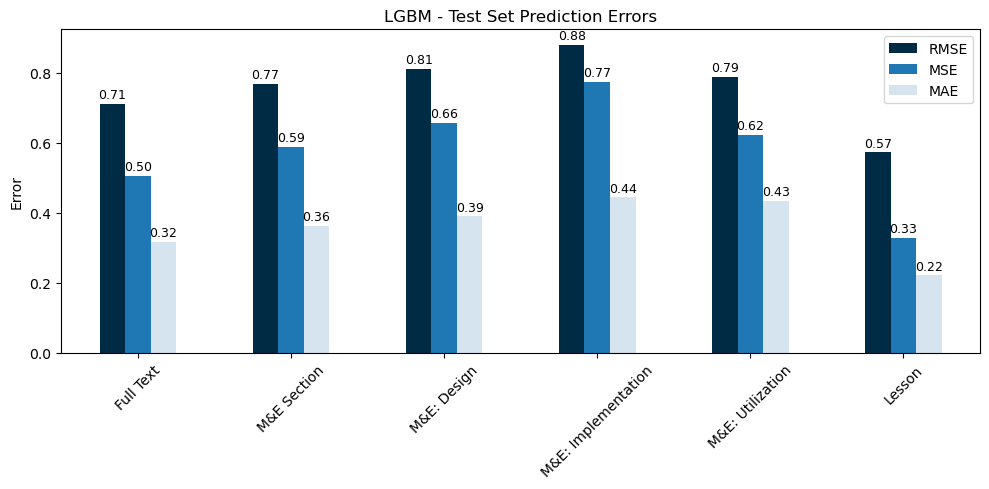

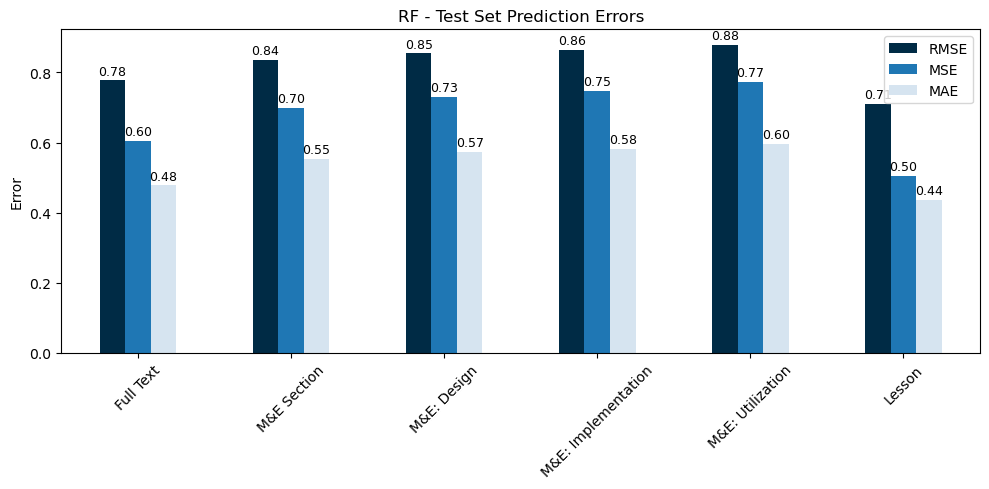

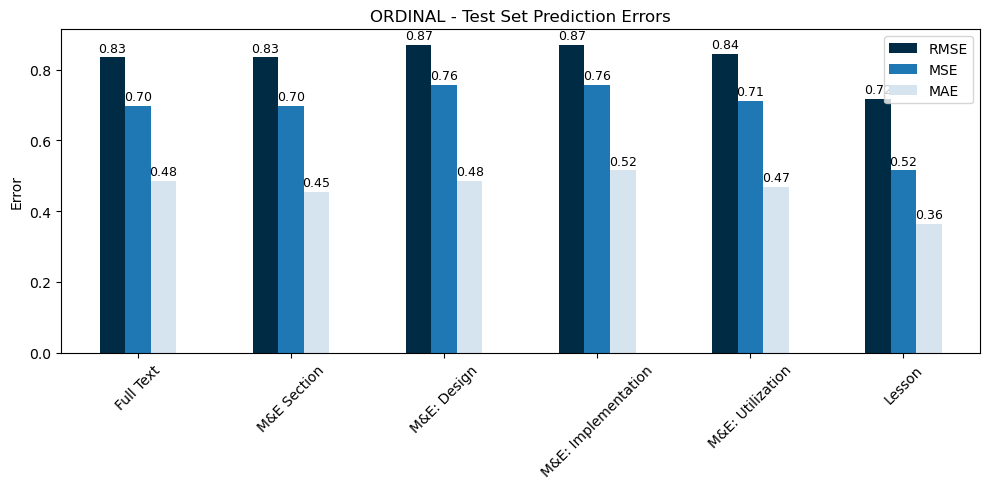

In [10]:
# Custom colors
custom_colors = ['#002b45', '#1f77b4', '#d6e4f0']

metrics_dict = {'lgbm': [], 'rf': [], 'ordinal': []}
labels = ['Full Text', 'M&E Section', 'M&E: Design', 'M&E: Implementation', 'M&E: Utilization', 'Lesson']

for model_type in ['lgbm', 'rf', 'ordinal']:
    for var in text_vars:
        filename = os.path.join(data_dir, f"model_{model_type}_{var}.pkl")
        with open(filename, 'rb') as f:
            data = pickle.load(f)

        model = data['model']
        vectorizer = data['vectorizer']

        X_all = vectorizer.transform(df2_cleaned[var])
        y_all = df2_cleaned["outcome_score"].astype(int)
        _, X_test, _, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

        y_pred = model.predict(X_test)

        rmse = mean_squared_error(y_test, y_pred, squared=False)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)

        metrics_dict[model_type].append({'RMSE': rmse, 'MSE': mse, 'MAE': mae})

# Plot results with custom colors and value labels
for model_type in ['lgbm', 'rf', 'ordinal']:
    df_metric = pd.DataFrame(metrics_dict[model_type], index=labels)
    df_metric = df_metric[['RMSE', 'MSE', 'MAE']]

    ax = df_metric.plot(
        kind='bar',
        figsize=(10, 5),
        color=custom_colors,
        title=f'{model_type.upper()} - Test Set Prediction Errors'
    )
    plt.xticks(rotation=45)
    plt.ylabel("Error")
    plt.tight_layout()

    # Add value labels above bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=9, padding=2)

    plt.show()

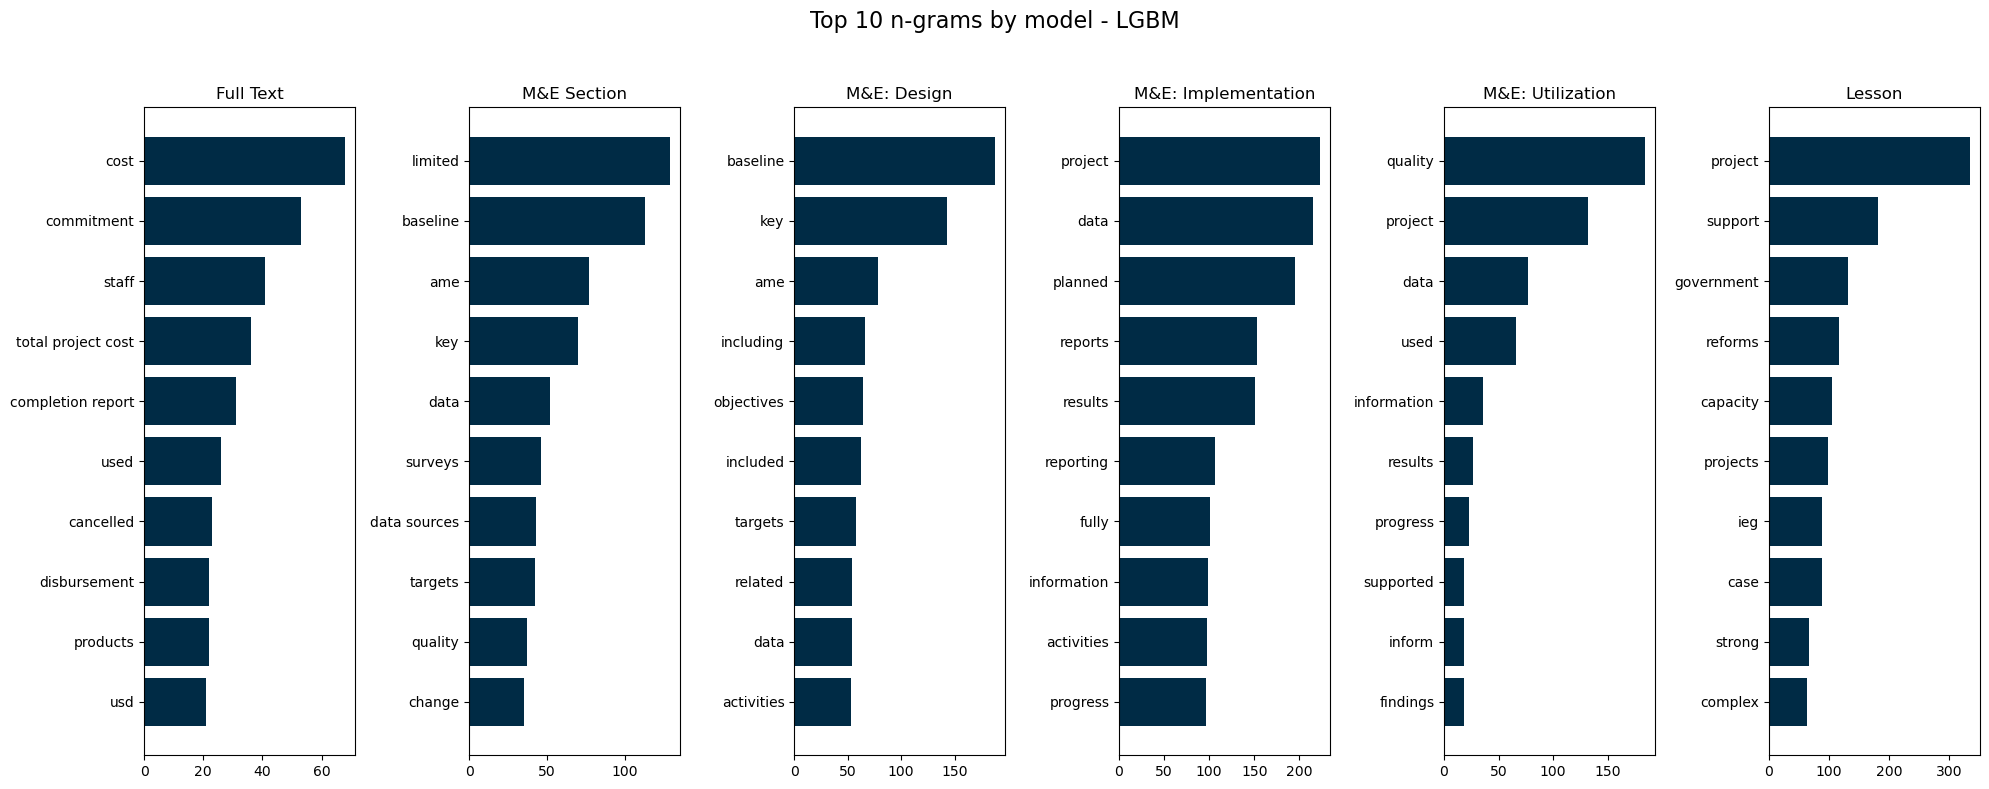

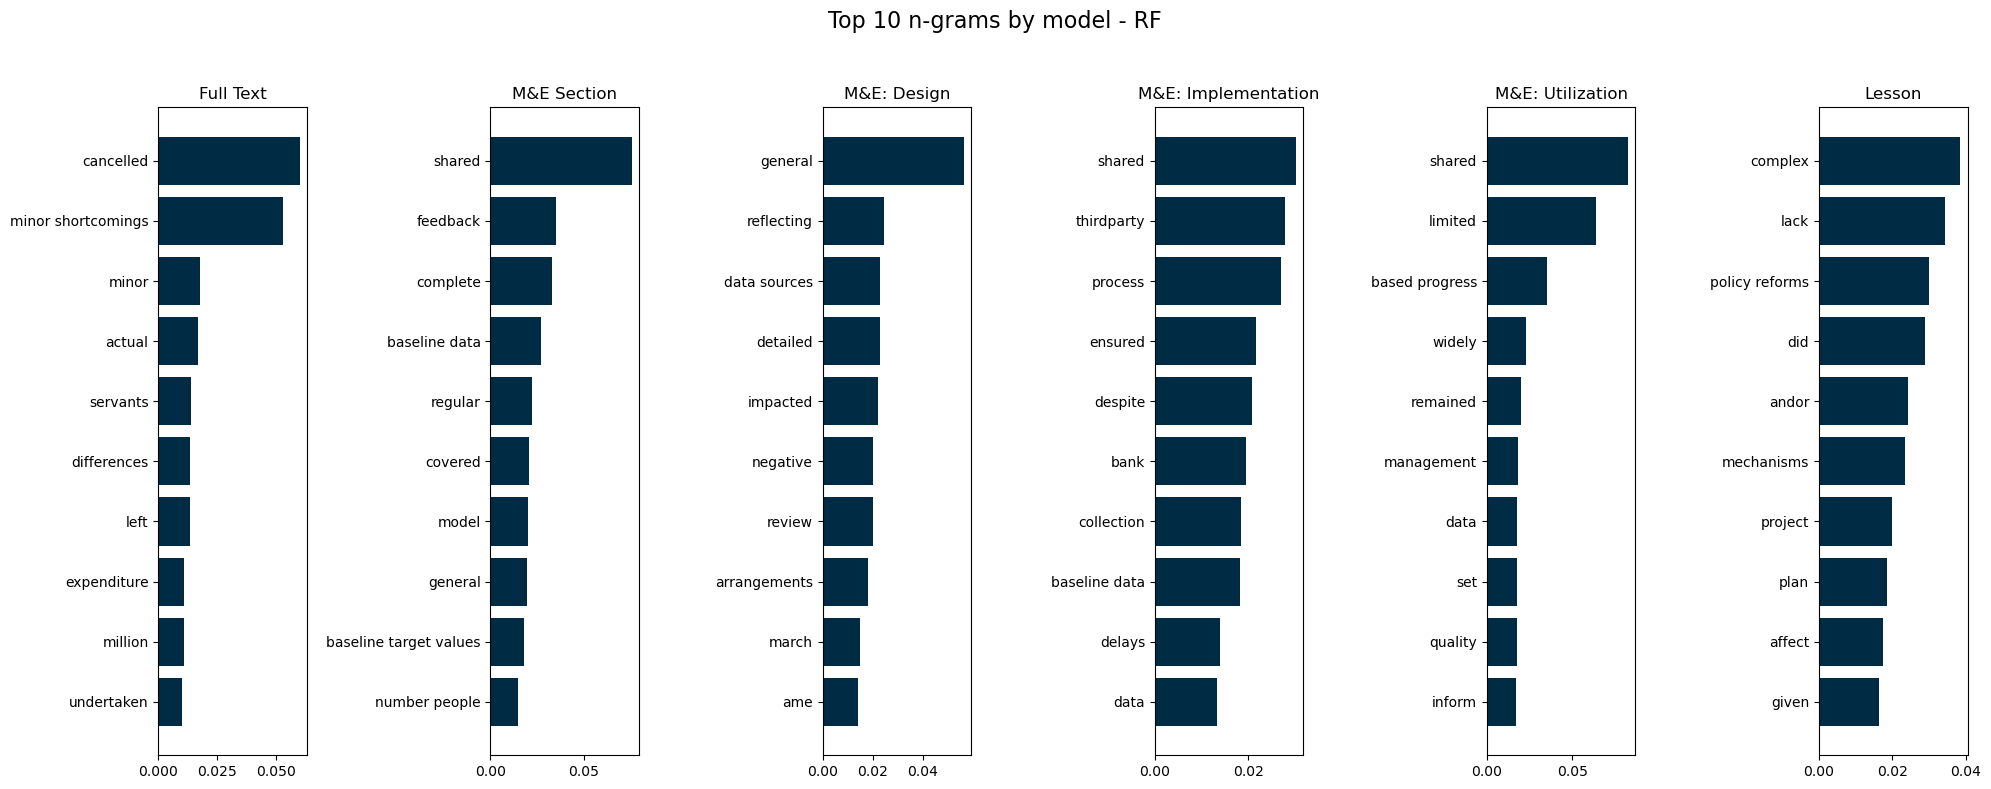

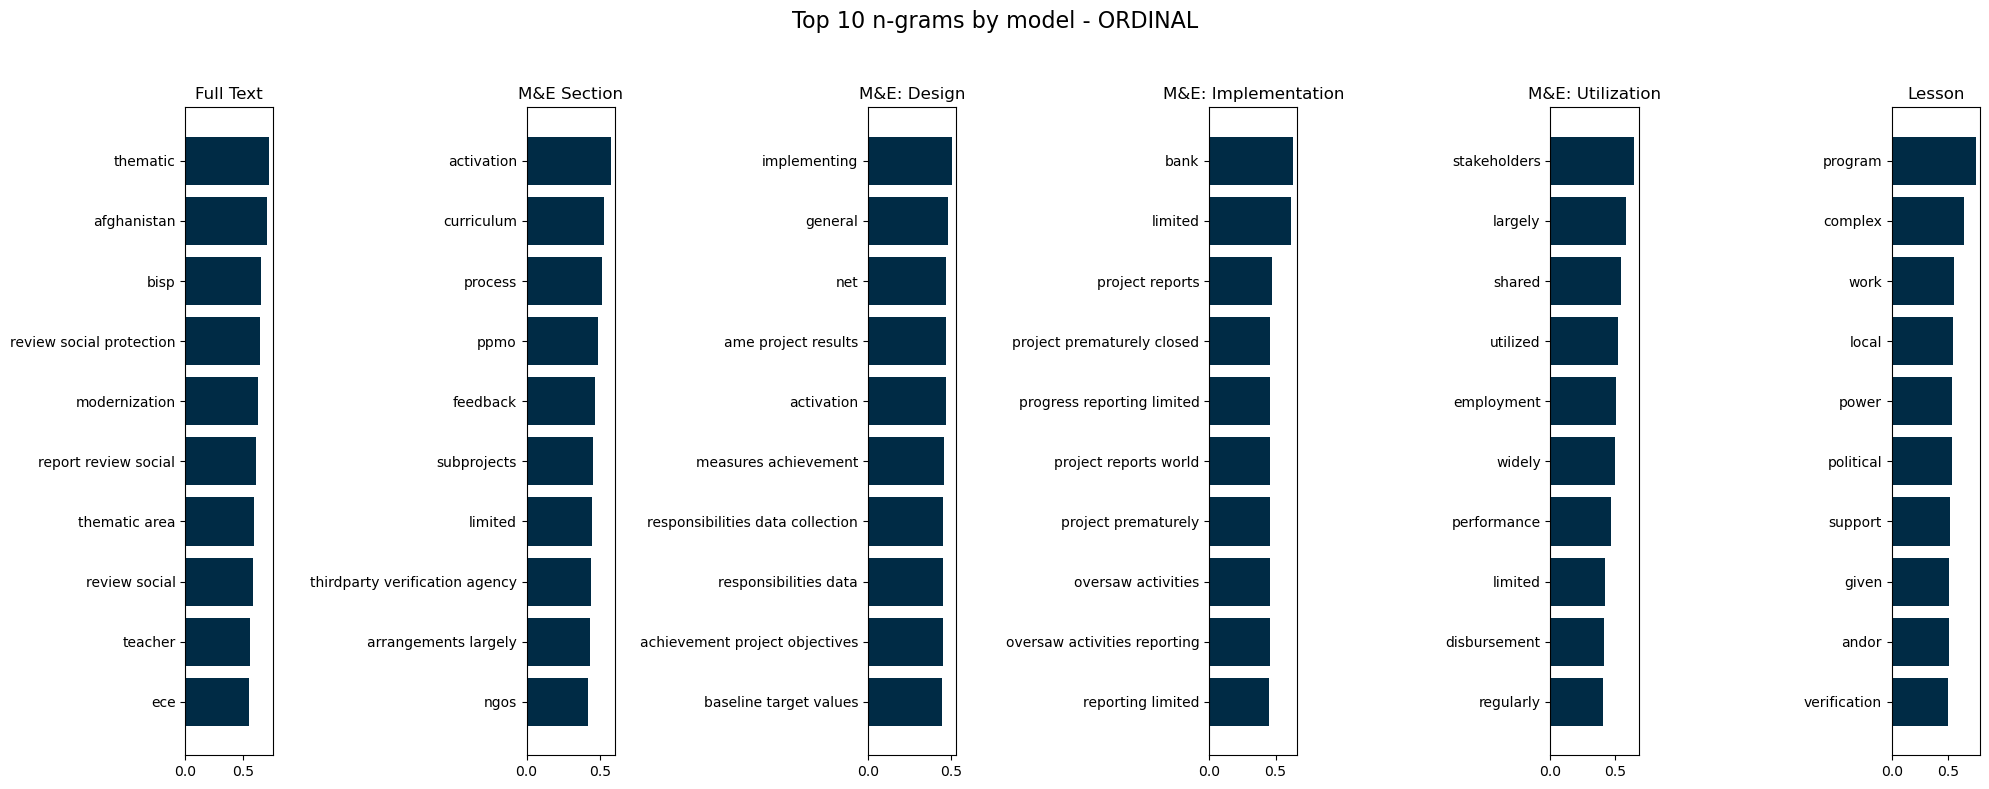

In [13]:
# Variable Importance Plot
for model_type in ['lgbm', 'rf', 'ordinal']:
    fig, axes = plt.subplots(1, 6, figsize=(20, 8))
    fig.suptitle(f"Top 10 n-grams by model - {model_type.upper()}", fontsize=16)

    for i, var in enumerate(text_vars):
        filename = os.path.join(data_dir, f"model_{model_type}_{var}.pkl")
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        model, vec = data['model'], data['vectorizer']

        # Get feature importances
        if model_type == 'ordinal':
            importances = np.abs(model.coef_).flatten()
        else:
            importances = model.feature_importances_

        features = np.array(vec.get_feature_names_out())
        idx = np.argsort(importances)[-10:][::-1]  # Top 10 features

        # Plot horizontal bar chart
        axes[i].barh(features[idx], importances[idx], color='#002b45')
        axes[i].set_title(var)
        axes[i].invert_yaxis()

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for suptitle
    plt.show()